<a href="https://colab.research.google.com/github/henokwon/Reboot-The-Earth/blob/main/Reboot_The_Earth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Set up**

In [ ]:
%pip install geemap

In [ ]:
import ee
import folium
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
ee.Authenticate()
ee.Initialize()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Visualize drought indicators**

In [ ]:

# Authenticate and initialize the Earth Engine API
ee.Authenticate()
ee.Initialize()

In [ ]:
# Specify the path to your CSV file
csv_file_path = '/content/drive/My Drive/PDSI.csv'

# Load the data into a DataFrame
pdsi_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
pdsi_df.head()

,system:time_start,Addis Ababa
0,1-Jul-00,-0.34060
1,1-Aug-00,-0.96895
2,1-Sep-00,-0.71468
3,1-Oct-00,-0.86590
4,1-Nov-00,0.09213


In [ ]:
# Convert the date column to datetime format
pdsi_df['system:time_start'] = pd.to_datetime(pdsi_df['system:time_start'])

# Set the date column as the index
pdsi_df.set_index('system:time_start', inplace=True)

# Display the DataFrame to check the changes
pdsi_df.head()


,Addis Ababa
system:time_start,
2000-07-01,-0.34060
2000-08-01,-0.96895
2000-09-01,-0.71468
2000-10-01,-0.86590
2000-11-01,0.09213


In [158]:
!pip install statsmodels

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


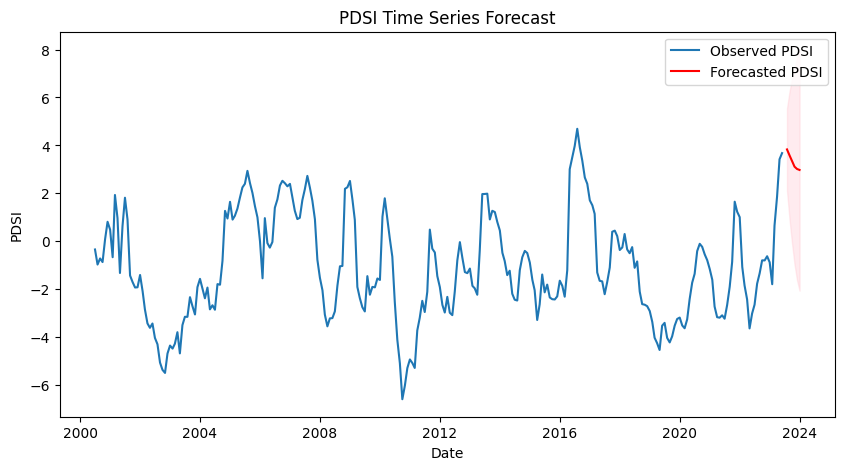

In [162]:
# Fit an ARIMA model
model = ARIMA(pdsi_df['Addis Ababa'], order=(5, 1, 0))
model_fit = model.fit()

# Make a forecast
forecast_steps = 6  # Number of months to forecast
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Create a date range for the forecast period
forecast_dates = pd.date_range(start=pdsi_df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(pdsi_df.index, pdsi_df['Addis Ababa'], label='Observed PDSI')
plt.plot(forecast_dates, forecast_mean, label='Forecasted PDSI', color='red')
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('PDSI')
plt.legend()
plt.title('PDSI Time Series Forecast')
plt.show()

In [143]:
# Load your PDSI data
# Assuming pdsi_df is your DataFrame with 'date' as index and 'pdsi' as the column

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [167]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load your PDSI data
# Assuming pdsi_df is your DataFrame with 'date' as index and 'pdsi' as the column

# Convert index to datetime if needed
pdsi_df.index = pd.to_datetime(pdsi_df.index)

# Normalize the data
scaler = MinMaxScaler()
pdsi_normalized = scaler.fit_transform(pdsi_df)

# Define function to create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Define function to forecast PDSI for a given number of months
def forecast_pdsi(model, data, sequence_length, num_months):
    forecast = []
    last_sequence = data[-sequence_length:]
    for _ in range(num_months):
        prediction = model.predict(last_sequence.reshape(1, sequence_length, 1))[0][0]
        forecast.append(prediction)
        last_sequence = np.append(last_sequence[1:], prediction).reshape(sequence_length, 1)
    return forecast

# Define sequence length
sequence_length = 12  # Example sequence length

# Create sequences for LSTM
X, y = create_sequences(pdsi_normalized, sequence_length)

# Split data into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Train Loss:', train_loss)
print('Test Loss:', test_loss)


# Specify the number of months to forecast
num_months_forecast = 3  # Example: forecast PDSI for the next 3 months

# Make predictions
predictions = forecast_pdsi(model, pdsi_normalized, sequence_length, num_months_forecast)

# Inverse transform predictions
predictions_inv = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


# Print the predicted PDSI values for each month
for i, prediction in enumerate(predictions_inv):
    print(f"Predicted PDSI for month {i+1}: {prediction[0]}")

# Evaluate the model using test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', test_loss)

# Extract actual PDSI values and dates from the test dataset
actual_values = test[-num_months_forecast:]  # Assuming the last `num_months_forecast` values are for testing
actual_dates = test.index[-num_months_forecast:]  # Assuming the dates are in the index

# Calculate metrics (e.g., MAE)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(actual_values, predictions_inv)
print('Mean Absolute Error:', mae)



Epoch 1/100
7/7 [==============================] - 2s 8ms/step - loss: 0.3033
Epoch 2/100
7/7 [==============================] - 0s 8ms/step - loss: 0.2290
Epoch 3/100
7/7 [==============================] - 0s 10ms/step - loss: 0.1684
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.1108
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0567
Epoch 6/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0324
Epoch 7/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0341
Epoch 8/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0284
Epoch 9/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0283
Epoch 10/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0261
Epoch 11/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0255
Epoch 12/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0249
Epoch 13/100
7/7 [==============================] - 0s 9m